In [1]:
# ایمپورت کتابخونه های مورد نیاز 
from sklearn.datasets import make_blobs
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import random

Text(0, 0.5, 'Y')

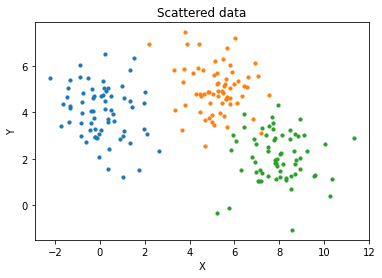

In [2]:
# تولید دیتای بنچ مارک
# این دیتاست 3 کلاس دارد که آن را با رنگ های آبی ، نارنجی و بنفش نشان داده ایم 
centers = [(0, 4), (5, 5) , (8,2)]
cluster_std = [1.2, 1, 1.1]

X, y= make_blobs(n_samples=200, cluster_std=cluster_std, centers=centers, n_features=2, random_state=1)



'''
centers1 = [[0, 0], [2, 6], [8, 10]]

X, y = make_blobs(n_samples=500, centers=centers1, 
                  cluster_std=1, random_state=0)



centers2 = [[0, 2], [2, 5], [6, 8]]

X, y = make_blobs(n_samples=400, centers=centers2, 
                  cluster_std=0.9, random_state=0)


centers3 = [[2,2], [2, 6], [3, 0]]

#Create dataset
X, y = make_blobs(n_samples=350, centers=centers3, 
                  cluster_std=0.8, random_state=0)


'''
plt.scatter(X[y == 0, 0], X[y == 0, 1], s=10, label="Cluster1")
plt.scatter(X[y == 1, 0], X[y == 1, 1], s=10, label="Cluster2")
plt.scatter(X[y == 2, 0], X[y == 2, 1], s=10, label="Cluster3")
plt.title("Scattered data")
plt.xlabel('X')
plt.ylabel('Y')

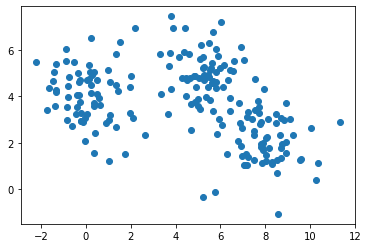

In [3]:
plt.scatter(X[:,0],X[:,1]) # نمایش دیتا بدون لیبل

# پیاده سازی با استفاده از ساختمان داده استک

In [4]:
# این تابع به هر نقطه ای نگاه میندازه و بررسی میکنه که آیا این نقطه یک نقطه حاشیه ای است یا نقطه اصلی یا نقطه نویزی 
def check_core_point(eps,minPts, df, index):
    # گرفتن یک داده از اندیس مورد نظر
    x, y = df.iloc[index]['X']  ,  df.iloc[index]['Y']
    
    # چک میکند آیا نقاط قابل دسترس در داخل شعاع هستند یا نه
    temp =  df[((np.abs(x - df['X']) <= eps) & (np.abs(y - df['Y']) <= eps)) & (df.index != index)]
    
    # چک میکند چه تعداد نقطه داخل شعاع باید باشد
    if len(temp) >= minPts:
        # (dataframe, is_core, is_border, is_noise)  با این فرمت اطلاعات رو برمیگردونیم
        return (temp.index , True, False, False)
    
    elif (len(temp) < minPts) and len(temp) > 0:
        # (dataframe, is_core, is_border, is_noise) با این فرمت اطلاعات رو بر میگردونیم 
        return (temp.index , False, True, False)
    
    elif len(temp) == 0:
        # (dataframe, is_core, is_border, is_noise) با این فرمت اطلاعات رو بر میگردونیم
        return (temp.index , False, False, True)

## تابع اصلی

In [5]:

def cluster_with_stack(eps, minPts, df):
    
    # مقداردهی اولیه شماره خوشه
    C = 1
    # مقداردهی اولیه استک برای نگهداری داده ها
    current_stack = set()
    unvisited = list(df.index)
    clusters = []
    
    
    while (len(unvisited) != 0): # این کد اجرا میشه تا زمانی که همه نقطه ها رو بررسی کرده باشیم

        # یک شناسه برای اولین داده ی خوشه
        first_point = True
        
        # یک داده رندم بررسی نشده انتخاب میکنیم
        current_stack.add(random.choice(unvisited))
        
        while len(current_stack) != 0: # تا زمانی که خوشه کامل میشه این کد اجرا باید بشه
            
            # داده فعلی رو از استک بر میداریم
            curr_idx = current_stack.pop()
            
            # بررسی میکنه آیا نقطه(داده) یک داده اصلی یا حاشیه ای یا نویز است
            neigh_indexes, iscore, isborder, isnoise = check_core_point(eps, minPts, df, curr_idx)
            
            if (isborder & first_point):                
                clusters.append((curr_idx, 0))
                clusters.extend(list(zip(neigh_indexes,[0 for _ in range(len(neigh_indexes))])))
                
                # داده رو به عنوان یک داده ویزیت شده لیبل میزنیم
                unvisited.remove(curr_idx)
                unvisited = [e for e in unvisited if e not in neigh_indexes]
    
                continue
                
            unvisited.remove(curr_idx) # حذف نقطه از لیست دیده نشده ها
            
            
            neigh_indexes = set(neigh_indexes) & set(unvisited) # فقط نقاط دیده نشده رو نگاه میکنه
            
            if iscore: # اگر داده فعلی یک نقطه اصلی باشد
                first_point = False
                
                clusters.append((curr_idx,C)) # اختصاص دهی نقطه به خوشه
                current_stack.update(neigh_indexes) # اضافه کردن همسایه به استک

            elif isborder: # آیا داده فعلی ، یک نقطه حاشیه ای است یا نه
                clusters.append((curr_idx,C))
                
                continue

            elif isnoise: # آیا داده فعلی یک نقطه نویزی است یا نه
                clusters.append((curr_idx, 0))
                
                continue
                
        if not first_point:
            #افزایش تعداد خوشه ها
            C+=1
        
    return clusters
            

## اجرای الگوریتم و چک کردن نتایج

In [6]:
# مقدار شعاع دایره را تعریف میکنیم
eps = 0.6
# تعداد حداقل نقاط همسایه را برابر 3 در نظر میگیریم
minPts = 3

In [7]:
data = pd.DataFrame(X, columns = ["X", "Y"] )
clustered = cluster_with_stack(eps, minPts, data)

In [8]:
clustered[0]

(136, 1)

In [9]:
idx , cluster = list(zip(*clustered))

In [10]:
cluster_df = pd.DataFrame(clustered, columns = ["idx", "cluster"])

Text(0, 0.5, 'Y')

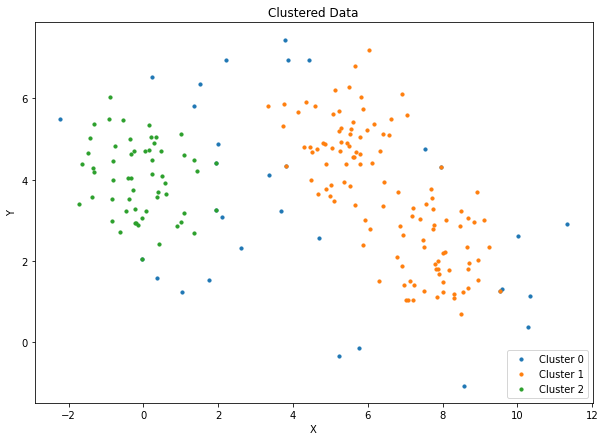

In [11]:
plt.figure(figsize=(10,7))
for clust in np.unique(cluster):
    # X[cluster_df["idx"][cluster_df["cluster"] == clust].values, 2] = clust
    
    plt.scatter(X[cluster_df["idx"][cluster_df["cluster"] == clust].values, 0], X[cluster_df["idx"][cluster_df["cluster"] == clust].values, 1], s=10, label=f"Cluster{clust}")

plt.legend([f"Cluster {clust}" for clust in np.unique(cluster)], loc ="lower right")
plt.title('Clustered Data')
plt.xlabel('X')
plt.ylabel('Y')


In [ ]:
'''
همونطور که در خروجی های بالا دیده میشه به نظر میرسه که کلاسترهای منطقی ای رو تونستیم تولید کنیم
و تعداد 2 کلاستر به همراه تعدادی نویز رو این الگوریتم تونسته برای ما ایجاد کنه
اگرچه احساس میشه که بعضی از نقاط به اشتباه در کلاستر دیگه ای قرار داده شدن .... با بازی کردن با متغیر های 
epsilon
و
min-points 
میتونیم به نتایج بهتری دست یپدا کنیم 

'''

'\nهمونطور که در خروجی های بالا دیده میشه به نظر میرسه که کلاسترهای منطقی ای رو تونستیم تولید کنیم\nو تعداد 3 کلاستر رو این الگوریتم تونسته برای ما ایجاد کنه که برابر با تعداد خوشه های دیتاست اصلی هستش\nاگر احساس میکنید که بعضی از نقاط به اشتباه در کلاستر دیگه ای قرار داده شدن .... با بازی کردن با متغیر های \nepsilon\nو\nmin-points \nمیتونیم به نتایج بهتری دست یپدا کنیم \n\n'